In [19]:
%pylab inline
import nengo_spa as spa
import nengo
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.builder import default_n_eval_points

import nengo_ssp as ssp

Populating the interactive namespace from numpy and matplotlib


We want to represent an SSP $S(x(t),y(t))$ that is changing over time given the initial SSP $S(x(0),y(0))$ and velocity inputs $\dot{x}$, $\dot{y}$.

\begin{align}
\dot{S}(x(t), y(t)) &= \frac{d}{dt} \mathcal{F}^{-1} \{ \mathcal{F}\{X\}^{x(t)} \odot \mathcal{F}\{Y\}^{y(t)} \} \\
&= \sum_{j=0}^{d-1} \frac{d}{dt} (\mathcal{F}\{X\}_j^{x(t)} \mathcal{F}\{Y\}_j^{y(t)}) e^{i2\pi n j /d} \\
&= \sum_{j=0}^{d-1} \frac{d}{dt} (e^{i\theta_{x,j} x(t)}e^{i\theta_{y,j} y(t)}) e^{i2\pi n j /d} \\
&= \sum_{j=0}^{d-1} i(\dot{x}(t) \theta_{x,j} + \dot{y}(t) \theta_{y,j}) (e^{i\theta_{x,j} x(t)}e^{i\theta_{y,j} y(t)}) e^{i2\pi n j /d} \\
&= \sum_{j=0}^{d-1} i(\dot{x}(t) \theta_{x,j} + \dot{y}(t) \theta_{y,j}) \mathcal{F}\{X\}_j^{x(t)} \mathcal{F}\{Y\}_j^{y(t)} e^{i2\pi n j /d} \\
&=  \mathcal{F}^{-1} \{i(\dot{x}(t) \vec{\theta}_{x} + \dot{y}(t) \vec{\theta}_{y}) \odot \bar{X}^{x(t)} \odot \bar{Y}^{y(t)} \} \\
&= S(x(t), y(t)) \circledast  i\left(\dot{x}(t) \mathcal{F}^{-1} \{ \vec{\theta}_{x}\} +  \dot{y}(t)  \mathcal{F}^{-1} \{ \vec{\theta}_{y} \} \right ) \\
&= S(x(t), y(t)) \circledast  \left (\dot{x}(t) \mathcal{F}^{-1} \{ \ln \mathcal{F}\{ X\} \} +  \dot{y}(t)  \mathcal{F}^{-1} \{ \ln \mathcal{F}\{ Y\} \} \right )
\end{align}


In [7]:

n_scales = 10
n_rotates = 10
N = n_scales*n_rotates
X, Y, K_scale_rotates = ssp.HexagonalBasis(n_scales,n_rotates)
d = X.v.shape[0]

xy_rad = 10
xs = np.linspace(-xy_rad,xy_rad,100)
ys = np.linspace(-xy_rad,xy_rad,100)

The path to follow:

In [21]:
dir(ssp)

['GridCellEncoders',
 'HexagonalBasis',
 'PlaneWaveBasis',
 'RecursiveBasisFun',
 'SpatialSemanticPointer',
 'UnitaryVectors',
 'WeightedPlaneWaveBasis',
 '__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__email__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'nengo_ssp',
 'networks',
 'vector_generation']

In [22]:
T = 20
dt = 0.001
timesteps = np.arange(0, T, dt)
#path,_ = generate_signal(T, dt, dims=2, rms=8,limit=0.05, seed=2)
#path = 3*np.vstack([np.sin(2*np.pi*timesteps/T),np.cos(2*np.pi*timesteps/T) - 1]).T
path,_ = ssp.utils.generate_signal(T, dt, dims=2, rms=6,limit=0.1, seed=2)

pathlen = path.shape[0]
vels = (1/dt)*( path[(np.minimum(floor(timesteps/dt) + 1, pathlen-1)).astype(int),:] -
               path[(np.minimum(floor(timesteps/dt), pathlen-2)).astype(int),:])
max_v = np.max(np.abs(vels))
figure(figsize=(10,5))
subplot(1,2,1)
plot(path[:,0],path[:,1],alpha=0.3)
quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
subplot(1,2,2)
plot(path[0:200,0],path[0:200,1],alpha=0.3)
quiver(path[0:500:100,0],path[0:500:100,1], vels[0:500:100,0], vels[0:500:100,1], angles='xy', scale_units='xy',scale=5)



AttributeError: module 'nengo_ssp' has no attribute 'utils'

In [64]:

def get_heatmap_vectors(xs, ys, x_axis_sp, y_axis_sp):
    """
    Precompute spatial semantic pointers for every location in the linspace
    Used to quickly compute heat maps by a simple vectorized dot product (matrix multiplication)
    """
    if (x_axis_sp.__class__.__name__ == 'SemanticPointer') or (x_axis_sp.__class__.__name__ == 'SpatialSemanticPointer'):
        dim = len(x_axis_sp.v)
    else:
        dim = len(x_axis_sp)
        x_axis_sp = spa.SemanticPointer(data=x_axis_sp)
        y_axis_sp = spa.SemanticPointer(data=y_axis_sp)

    vectors = np.zeros((len(xs), len(ys), dim))

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            p = x_axis_sp**x * y_axis_sp**y
            vectors[i, j, :] = p.v

    return vectors

    
# From github.com/ctn-waterloo/cogsci2019-ssp
def loc_match(sp, heatmap_vectors, xs, ys):
    if (sp.__class__.__name__ == 'SemanticPointer') or (sp.__class__.__name__ == 'SpatialSemanticPointer'):
        vs = np.tensordot(sp.v, heatmap_vectors, axes=([0], [2]))
    else:
        vs = np.tensordot(sp, heatmap_vectors, axes=([0], [2]))

    xy = np.unravel_index(vs.argmax(), vs.shape)

    x = xs[xy[0]]
    y = ys[xy[1]]
    return x,y, vs[xy]

def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S.real

def plot_sim_path(ts, ssp_p,path):
    tlen = ts.shape[0]
    sim_pts = np.zeros((tlen,2))
    sim_pt_dists = np.zeros(tlen)

    pt_confids = np.zeros(tlen)
    heatmap_t = np.zeros((len(xs),len(ys)))
    heatmap_vectors = get_heatmap_vectors(xs, ys, X, Y)
    for i in np.arange(tlen):
        heatmap_t = heatmap_t + np.tensordot(ssp_p[i,:].reshape(-1), heatmap_vectors, axes=([0], [2]))
        xt, yt, ptcon = loc_match(ssp_p[i,:].reshape(-1), heatmap_vectors, xs, ys)
        pt_confids[i] = ptcon
        sim_pts[i,:] = np.array([xt,yt])
        sim_pt_dists[i] = np.linalg.norm(sim_pts[i,:]-path[i,:])
        
    figure(figsize=(12,6))
    subplot(1,2,1)
    scatter(ts, sim_pt_dists, s=2, c = pt_confids, alpha=0.5)
    xlabel("time")
    ylabel("distance to true position")
    subplot(1,2,2)
    scatter(sim_pts[:,0], sim_pts[:,1],s=2, c = pt_confids, alpha=0.5)
    plot(path[:,0], path[:,1],'r')
    scatter(sim_pts[5,0], sim_pts[5,1],s=50, c="r",marker="+")
    colorbar()
    
    return sim_pts, sim_pt_dists, pt_confids

## Binding network path integrator 

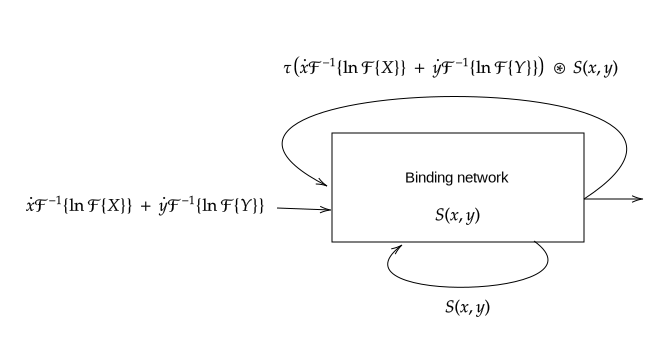

In [4]:
SVG(filename='diagram-20200821.svg')

In [12]:
n_neurons = 500
thetas = np.vstack([1.j * K_scale_rotates,np.zeros((1,2)),np.flip(-1.j * K_scale_rotates, axis=0)])
lnT = np.fft.ifft(np.fft.ifftshift(thetas), axis=0).real
lnT[:,[0, 1]] = lnT[:,[1, 0]]
lnX = lnT[:,0]
lnY = lnT[:,1]


max_mag = np.max(np.linalg.norm(vels[:,0].reshape(-1,1) * np.tile(lnX,(vels[:,0].shape[0],1))  +
               vels[:,1].reshape(-1,1) * np.tile(lnY,(vels[:,1].shape[0],1)),axis=1 ))

# From Terry:
tau=0.1
model = nengo.Network(seed=1)
with model:
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    
    def ssp_normalize(x):
        return x/np.maximum(1e-8,np.sum(x**2))
    
    path_int = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,
                                                input_magnitude=max_mag)
    #path_int.output.output = lambda t, x: ssp_normalize(x) # normalizing helps in direct mode

    nengo.Connection(stim, path_int.output) #initialize
    nengo.Connection(stim_v, path_int.input_b, transform=lnT, synapse=tau)
    
    # do the "tau*dSSP" part of principle 3
    nengo.Connection(path_int.output, path_int.input_a, transform=tau, synapse=tau)
         
    # do the "+x" part of principle 3
    nengo.Connection(path_int.product.sq1.output, path_int.product.sq1.input,transform=0.5, synapse=tau)
    nengo.Connection(path_int.product.sq2.output, path_int.product.sq1.input,transform=0.5, synapse=tau)
    nengo.Connection(path_int.product.sq1.output, path_int.product.sq2.input,transform=0.5, synapse=tau)
    nengo.Connection(path_int.product.sq2.output, path_int.product.sq2.input,transform=0.5, synapse=tau)
  
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    v_p = nengo.Probe(path_int.input_b, synapse=.01)

In direct mode:

In [37]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

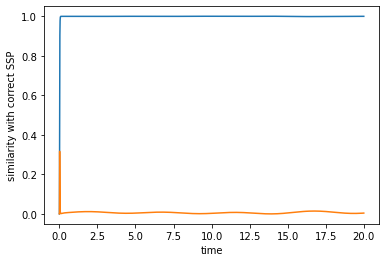

In [38]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bn_dir = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


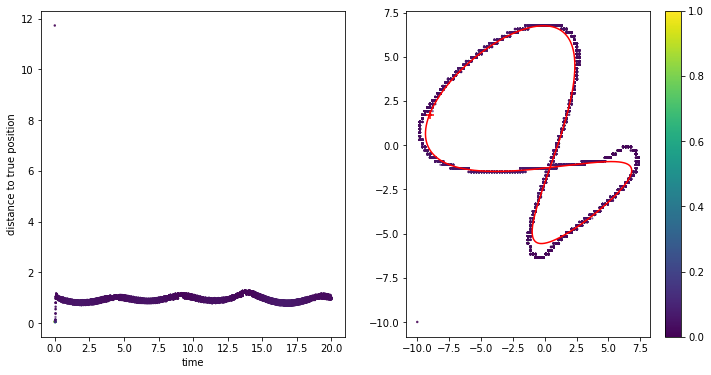

In [39]:
simpts_bn_dir, ptdists_bn_dir, ptconfid_bn_dir =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


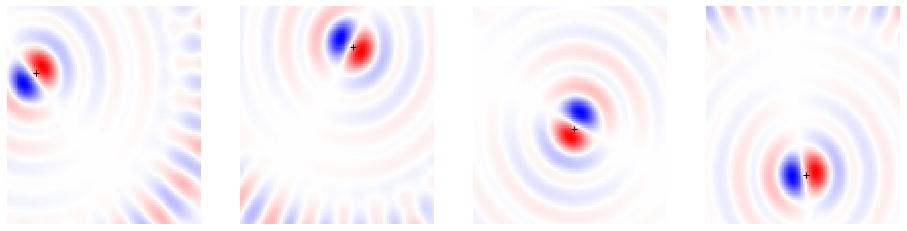

In [40]:
xx,yy = np.meshgrid(xs,ys)
basis = np.vstack([X.v, Y.v]).T
positions = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
position0 = np.array([0,0])
sim_dots0, S_list = similarity_values(basis,  positions, position0 = position0, S0 = sim.data[real_ssp_p][0,:])

fig, axs = plt.subplots(1,4,figsize=(16,4))
sample_t = np.linspace(1,10,  4)
for j in range(4):
    sim_dots, _ = ssp.plotting._similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In spiking mode:

In [41]:
for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIF()
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

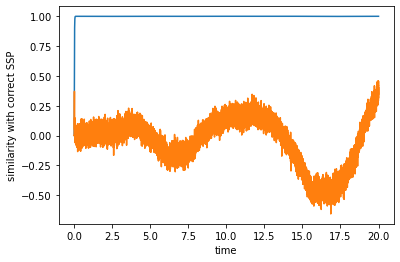

In [42]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bn_sp = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


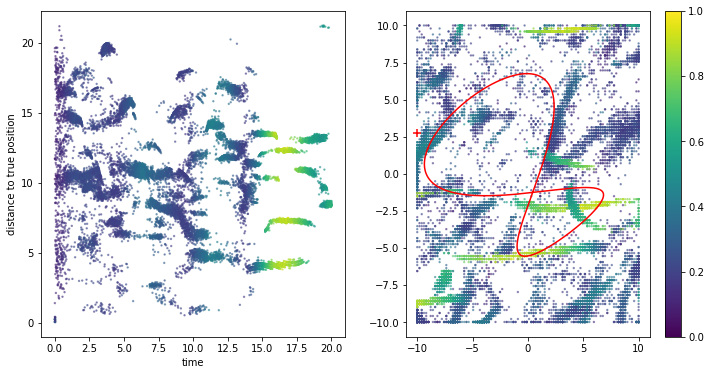

In [43]:
simpts_bn_sp, ptdists_bn_sp, ptconfid_bn_sp =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

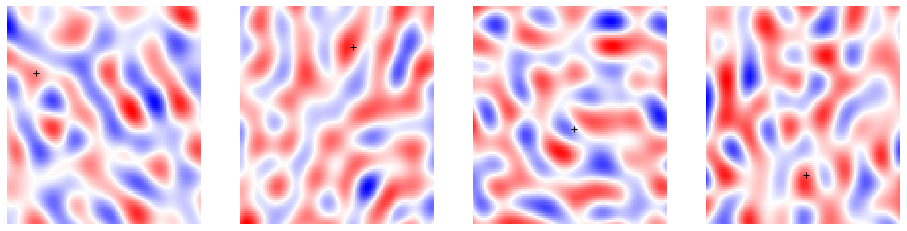

In [13]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = ssp.plotting._similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

### Binding network path integrator with grid cell population doing the "+x"

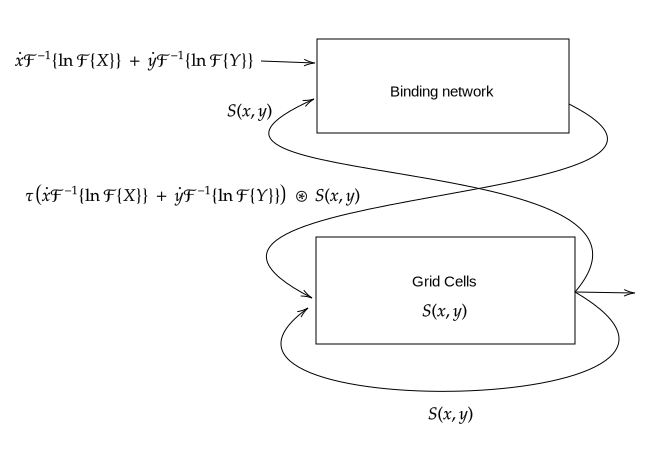

In [14]:
SVG(filename='diagram-20200821(1).svg')

(The network has been modified as per Terry's suggestion: the output of the binding network is also used input to the binding network)

In [65]:
n_G = 10000 # number of grid cells

G_encoders, G_sorts = ssp.GridCellEncoders(n_G,X,Y)

    
n_eval_pts = default_n_eval_points(n_G, d)
eval_xy = np.random.rand(n_eval_pts, 2)
eval_pts = ssp.utils.ssp_vectorized(np.vstack([X.v, Y.v]).T, eval_xy).real.T

/usr/local/lib/python3.8/dist-packages/nengo_ssp-0.1.0-py3.8.egg/nengo_ssp/vector_generation.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  G_encoders[i,:] = N * proj_mat @ ((Xi**G_pos[i,0])*(Yi**G_pos[i,1])).v


In [14]:
model = nengo.Network(seed=1)
with model:
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<30*dt else np.zeros((d,)))
    
    binding_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,
                                                input_magnitude=max_mag)
    
    gc_ens = nengo.Ensemble(n_G, dimensions=d, radius = 1, 
                         encoders = G_encoders, 
                        eval_points = eval_pts)
    
    nengo.Connection(stim, gc_ens) #initialize
    nengo.Connection(stim_v, binding_ens.input_b, transform=lnT, synapse=tau)
    
    def ssp_normalize(x):
        return x/np.maximum(1e-8,np.sum(x**2))
    
    nengo.Connection(binding_ens.output, gc_ens, synapse=tau,transform=tau)
    nengo.Connection(binding_ens.output, binding_ens.input_a, synapse=tau,transform=tau)
    #binding_ens.output.output = lambda t,x: ssp_normalize(x)
    nengo.Connection(gc_ens,gc_ens, synapse=tau,function=ssp_normalize)
    nengo.Connection(gc_ens,binding_ens.input_a, synapse=tau,function = ssp_normalize)
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(gc_ens, synapse=.01)
    ssp2_p = nengo.Probe(binding_ens.output, synapse=.01)

In direct mode:

In [15]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

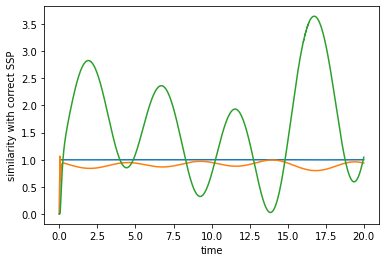

In [16]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bngc_dir = sim.data[ssp_p]

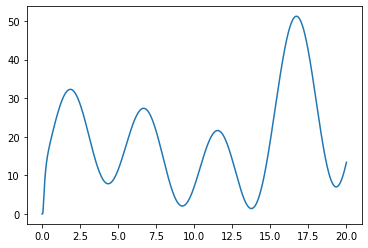

In [17]:
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[ssp2_p], axis=1))


/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


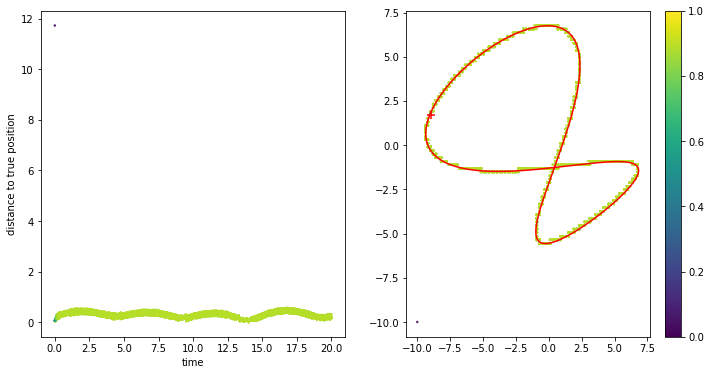

In [18]:
simpts_bngc_dir, ptdists_bngc_dir, ptconfid_bngc_dir =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

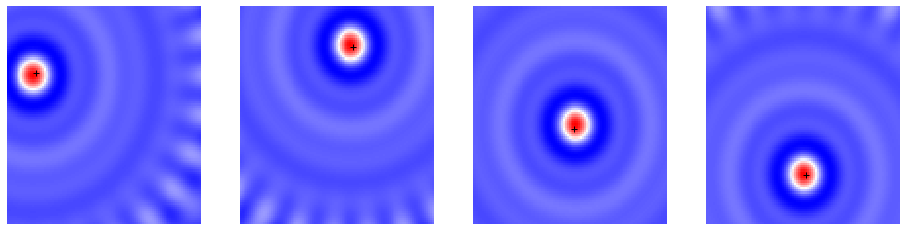

In [100]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = ssp.plotting._similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

Why is using a grid cell population so helpful?

SSPs are represented more accurately from grid cell populations. Note that least squares problem of decoding sampled SSPs from a population of neurons will look like the optimization problem of decoding place cell output - except that instead of $\Sigma$ being correlation matrix of place cell outputs, it is the correlation matrix of SSPs. A large matrix whose entries are dot products of SSPs uniformly covering space. From "A short letter on the dot productbetween rotated Fourier transforms", we know that these entries are samples of products of sinc functions. This matrix should be, in the limit of large numbers, transitional invariant and circularly symmetric (i.e. circulant). So it has the same important features as the place cell correlation matrix that leads to the conclusion that optimal neuron activitites are hexagonally patterned.



In rate mode:


In [23]:
model = nengo.Network(seed=1)
bn_max_mag = np.max(np.sum(sim.data[ssp2_p]*sim.data[ssp2_p], axis=1))
with model:
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<30*dt else np.zeros((d,)))
    
    binding_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,
                                                input_magnitude=bn_max_mag)
    
    gc_ens = nengo.Ensemble(n_G, dimensions=d, radius = 1, 
                         encoders = G_encoders, 
                        eval_points = eval_pts)
    
    nengo.Connection(stim, gc_ens) #initialize
    nengo.Connection(stim_v, binding_ens.input_b, transform=lnT, synapse=tau)
    
    def ssp_normalize(x):
        return x/np.maximum(1e-8,np.sum(x**2))
    
    nengo.Connection(binding_ens.output, gc_ens, synapse=tau,transform=tau)
    nengo.Connection(binding_ens.output, binding_ens.input_a, synapse=tau,transform=tau)
    #binding_ens.output.output = lambda t,x: ssp_normalize(x)
    nengo.Connection(gc_ens,gc_ens, synapse=tau,function=ssp_normalize)
    nengo.Connection(gc_ens,binding_ens.input_a, synapse=tau,function = ssp_normalize)
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(gc_ens, synapse=.01)
    ssp2_p = nengo.Probe(binding_ens.output, synapse=.01)

for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIFRate()
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

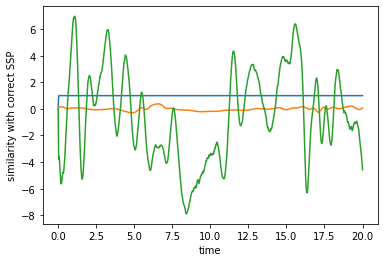

In [24]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bngc_sp = sim.data[ssp_p]

<ipython-input-9-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


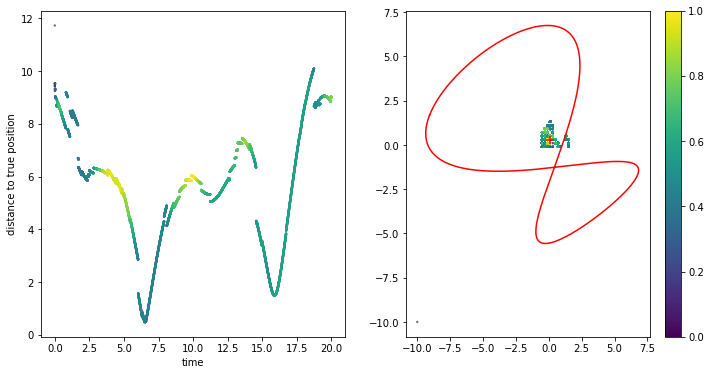

In [26]:
simpts_bngc_sp, ptdists_bngc_sp, ptconfid_bngc_sp =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

In [33]:
xx,yy = np.meshgrid(xs,ys)
basis = np.vstack([X.v, Y.v]).T
positions = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
position0 = np.array([0,0])
sim_dots0, S_list = ssp.plotting._similarity_values(basis,  positions, position0 = position0, S0 = sim.data[real_ssp_p][0,:])
sample_t = np.linspace(1,10,  4)



In [55]:
sss

array([[ 0.08553227-2.35128644e-16j,  0.11000838-2.84061946e-16j,
         0.11036118-1.83792295e-16j, ...,  0.13680497+9.72900236e-17j,
         0.16300493-1.50699835e-16j,  0.15422075-3.83643667e-16j],
       [ 0.0265407 -2.77538087e-16j,  0.04498983-1.99886475e-16j,
         0.04582017-1.37356719e-16j, ...,  0.08703787-8.01540189e-17j,
         0.11272272-2.39639336e-16j,  0.10269121-4.41278536e-16j],
       [-0.0396365 -1.32839719e-16j, -0.02004649-1.18737288e-17j,
        -0.01147061+1.21741965e-17j, ...,  0.03552124-6.53668557e-17j,
         0.06266835-2.03859243e-16j,  0.0531857 -4.21060830e-16j],
       ...,
       [-0.06579084+5.62114080e-18j,  0.0042998 +2.08302082e-16j,
         0.05423141+2.94799776e-16j, ...,  0.14088436-3.77945121e-17j,
         0.13716277-3.52641160e-17j,  0.08945075-2.29225931e-16j],
       [-0.0887769 +6.91418879e-17j, -0.01902608+1.85321584e-16j,
         0.02884891+2.35372311e-16j, ...,  0.09361191-6.86374588e-17j,
         0.07900858-1.36971617e-16j

In [54]:
plt.figure()
sss=sim_dots.reshape(xx.shape)
plt.pcolor(xx, yy, sss)

<ipython-input-54-a1d3fecda973>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(xx, yy, sss)


IndexError: arrays used as indices must be of integer (or boolean) type

<Figure size 432x288 with 1 Axes>

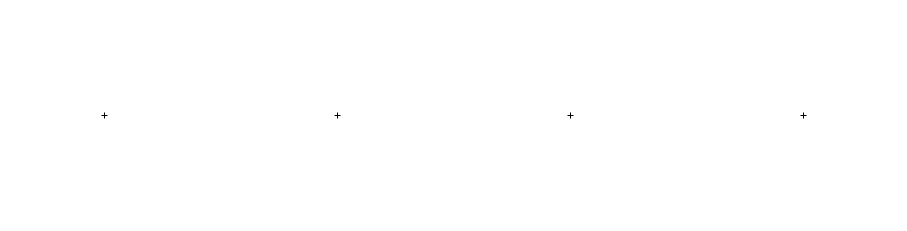

In [47]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = ssp.plotting._similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    #axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape),cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In [42]:
sim_dots.reshape(xx.shape)

array([[ 0.08553227-2.35128644e-16j,  0.11000838-2.84061946e-16j,
         0.11036118-1.83792295e-16j, ...,  0.13680497+9.72900236e-17j,
         0.16300493-1.50699835e-16j,  0.15422075-3.83643667e-16j],
       [ 0.0265407 -2.77538087e-16j,  0.04498983-1.99886475e-16j,
         0.04582017-1.37356719e-16j, ...,  0.08703787-8.01540189e-17j,
         0.11272272-2.39639336e-16j,  0.10269121-4.41278536e-16j],
       [-0.0396365 -1.32839719e-16j, -0.02004649-1.18737288e-17j,
        -0.01147061+1.21741965e-17j, ...,  0.03552124-6.53668557e-17j,
         0.06266835-2.03859243e-16j,  0.0531857 -4.21060830e-16j],
       ...,
       [-0.06579084+5.62114080e-18j,  0.0042998 +2.08302082e-16j,
         0.05423141+2.94799776e-16j, ...,  0.14088436-3.77945121e-17j,
         0.13716277-3.52641160e-17j,  0.08945075-2.29225931e-16j],
       [-0.0887769 +6.91418879e-17j, -0.01902608+1.85321584e-16j,
         0.02884891+2.35372311e-16j, ...,  0.09361191-6.86374588e-17j,
         0.07900858-1.36971617e-16j

## VCO & grid cells path integrator

Each ensemble in the ensemble array is representing the real and imaginary component of $\mathcal{F}\{ S\}_j = \bar{S}_j$ and the value $\dot{x} \theta_{x,j} + \dot{y}\theta_{y,j}$:
\begin{equation}
\begin{bmatrix}
 \dot{x} \theta_{x,j} + \dot{y}\theta_{y,j} \\
 \text{Re}(\bar{S}_j) \\
 \text{Im}(\bar{S}_j)
\end{bmatrix}
\end{equation}
This will be updated via velocity input and a recurrent connection:
\begin{align}
\begin{bmatrix}
0 \\
 -\tau(\dot{x}(t) \theta_{x,j} +  \dot{y}(t)  \theta_{y,j})\text{Im}(\bar{S}_j) + \text{Re}(\bar{S}_j) \\
 \tau(\dot{x}(t) \theta_{x,j} +  \dot{y}(t)  \theta_{y,j})\text{Re}(\bar{S}_j) + \text{Im}(\bar{S}_j)
\end{bmatrix} 
\end{align}

Note that this is like an oscillator with frequency $\dot{x}(t) \theta_{x,j} +  \dot{y}(t)  \theta_{y,j} = \vec{v} \cdot \vec{\theta}_j$. It's a velocity controlled oscillator (VCO) - a popular model for grid cells and path integration. 

The results of the set of populations representing $\bar{S}_j$ for $j=0,\dots, d//2$ can be linearly transformed to get the SSP $S(t)$, this will be represented by a population of grid cells

Comments on connection btwn SSP, VCOs, and continuous attractors:

An d-dim SSP lies on a d-Clifford torus. "A fundamental result states that the phase space trajectories of a Hamiltonian with n degrees of freedom lie on an n-dimensional manifold which is topologically equivalent to an n-torus" -- e.g. the phase space trajectories of a harmonic oscillator lie on a circle. The phase space trajectories of a set of d harmonic oscillators lie on the cartesian product of d circles - the definition of a d-Clifford torus. 

So moving around in a particular way corresponding to the input velocities on the d-Clifford torus (dynamics of the SSP) is equivalent to having a set of d harmonic oscillators whose motion depends on the input velocities in a particular way. 

What about continous attractor models of path integration? These are models of a dynamical system with a toroidal continuous attractor. Again, it's moving around a torus in a particular way that depends on the input velocities.


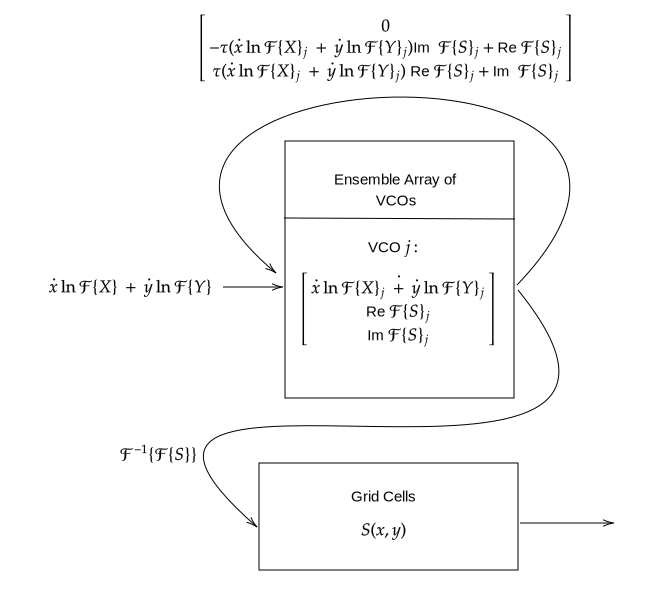

In [25]:
SVG(filename='diagram-20200821(2).svg')

In [66]:
myK = K_scale_rotates


n_oscs = d//2
real_ids = np.arange(1,n_oscs*3,3)
imag_ids = np.arange(2,n_oscs*3,3)
S_ids = np.zeros(n_oscs*2 + 1, dtype=int)
S_ids[0:d//2] = real_ids
S_ids[d//2:(n_oscs*2)] = imag_ids
S_ids[-1] = n_oscs*3 
i_S_ids = np.argsort(S_ids)

def exact_Fssp(t):
    S = exact_ssp(t)
    FS = np.fft.fftshift(np.fft.fft(S))
    realpart = FS.real[0:d//2]
    imagpart = FS.imag[0:d//2]
    res = np.zeros(d-1,)
    res[0:d//2] = realpart
    res[d//2:] = imagpart
    return res.real


def get_to_SSP_mat(D):
    W = np.fft.ifft(np.eye(D))
    W1 = W.real @ np.fft.ifftshift(np.eye(D),axes=0)
    W2 = W.imag @ np.fft.ifftshift(np.eye(D),axes=0)
    shiftmat1 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), np.flip(np.eye(D//2), axis=0)])
    shiftmat2 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), -np.flip(np.eye(D//2), axis=0)])
    shiftmat = np.vstack([ np.hstack([shiftmat1, np.zeros(shiftmat2.shape)]),
                          np.hstack([np.zeros(shiftmat2.shape), shiftmat2])])
    shiftmat = np.hstack([shiftmat, np.zeros((shiftmat.shape[0],1))])
    shiftmat[D//2,-1] = 1
    tr = np.hstack([W1, -W2]) @ shiftmat 
    return tr

def get_from_SSP_mat(D):
    W = np.fft.fft(np.eye(D))
    W1 = np.fft.fftshift(np.eye(D),axes=0) @ W.real 
    W2 = np.fft.fftshift(np.eye(D),axes=0) @ W.imag 
    shiftmat1 = np.hstack([np.eye(D//2), np.zeros((D//2, 2*(D//2) + D//2 + 2))])
    shiftmat2 = np.hstack([np.zeros((D//2, 2*(D//2) + 1)), np.eye(D//2), np.zeros((D//2, D//2 + 1))])
    shiftmat = np.vstack([ shiftmat1,shiftmat2])
    tr = shiftmat @ np.vstack([W1, W2]) 
    return tr

def as_SSP(x):
    r = np.maximum(np.sqrt(x[0:d//2]**2 + x[d//2:]**2), 1e-9)
    complex_x = (x[0:d//2] + 1.j*x[d//2:])/r
    complex_x = np.hstack([complex_x, 1, np.conj(complex_x)])
    return np.fft.ifft(np.fft.ifftshift(complex_x)).real

to_SSP = get_to_SSP_mat(d)
i_to_SSP = get_from_SSP_mat(d)


taus = 0.1*np.ones(n_oscs)
real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))
vels_scaled = vels*scale_fac

model = nengo.Network(seed=1)
with model:
    vel_stim = nengo.Node(lambda t: vels_scaled[int(t/dt)-1,:], size_out=2)
    vel_input = nengo.Ensemble(n_neurons, dimensions=2,label='velocity')
    FS_real = nengo.Node(exact_Fssp) # just for probes
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    stim2 = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    node1 = nengo.Node([1,0,0])
    
    osc = nengo.networks.EnsembleArray(n_neurons, n_oscs + 1, ens_dimensions = 3,radius=np.sqrt(3), label="osc")
    osc.output.output = lambda t, x: x # a hack
    S_out = nengo.Ensemble(n_G, dimensions=d, encoders = G_encoders, radius=np.sqrt(2), label="Sout")
    
    # We want dynamics with a unit circle limit cycle that is stable
    
    # Harmonic oscillator: simple but limit cycle is unstable :'(
    def feedback(x, tau): 
        w = x[0]/scale_fac
        dx1 = - x[2]*w
        dx2 =  x[1]*w
        return 0, tau*dx1 + x[1], tau*dx2 + x[2]
    
    # From \dot{r} = (1-r^2), \dot{theta}=2\pi freq
    def feedback_stable(x, tau):
        w = x[0]/(scale_fac)
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1 + x[1], tau*dx2 + x[2] 
    
    def feedback_stable2(x, tau):
        w = x[0]/scale_fac
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1, tau*dx2
    
    
    nengo.Connection(vel_stim, vel_input)
    for i in np.arange(n_oscs):
        nengo.Connection(vel_input, osc.ea_ensembles[i][0], transform = myK[i,:].reshape(1,-1),  
                         synapse=taus[i])
        nengo.Connection(stim[i], osc.ea_ensembles[i][1]) #initialize
        nengo.Connection(stim[i + d//2], osc.ea_ensembles[i][2]) #initialize
        nengo.Connection(osc.ea_ensembles[i], osc.ea_ensembles[i], 
                         function=lambda x: feedback_stable(x, taus[i]), #recurrent connection
                         synapse=taus[i])
        
    nengo.Connection(node1, osc.ea_ensembles[-1])
    connect = nengo.Connection(osc.output[S_ids], S_out, transform = to_SSP, synapse=taus[0])

    
    real_p = nengo.Probe(FS_real, synapse=.01)
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    osc_p = nengo.Probe(osc.output, synapse=.01)
    ssp_p = nengo.Probe(S_out, synapse=.01)



In direct mode:

In [50]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Examples of oscillators:

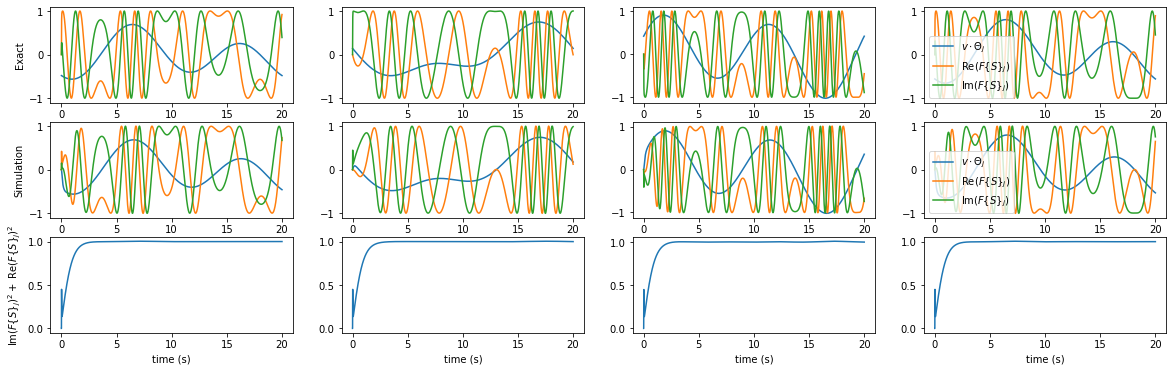

In [51]:
real_freqs_s = (vels_scaled @ myK.T)

sub_n_oscs = 4
figure(figsize=(20,6))
for i in np.arange(sub_n_oscs):
        
    j = i+ n_oscs - sub_n_oscs
    subplot(3,sub_n_oscs,i+1 )
    plot(sim.trange(), real_freqs_s[:, j])
    plot(sim.trange(), sim.data[real_p][:,[j, j + int(d//2)]])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$( F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Exact")
    
    subplot(3,sub_n_oscs, i+1 + sub_n_oscs)
    plot(sim.trange(), sim.data[osc_p][:,(3*j):3*(j+1)])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$(F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Simulation")
    
    subplot(3,sub_n_oscs, i+1 + 2*sub_n_oscs)
    plot(sim.trange(), np.sqrt( sim.data[osc_p][:,3*j+1]**2 +  sim.data[osc_p][:,3*(j+1)-1]**2 ))
    if i==0:
        ylabel("Im$(F\{S\}_j)^2 + $ Re$(F\{S\}_j)^2$")
    xlabel("time (s)")

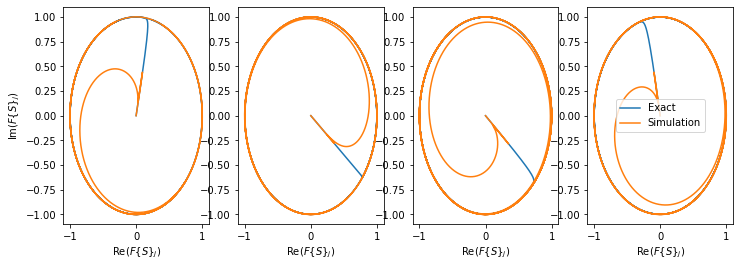

In [52]:
figure(figsize=(12,4))
for i in np.arange(sub_n_oscs):
    subplot(1,sub_n_oscs,i+1)
    plot(sim.data[real_p][:,i],  sim.data[real_p][:,i+ int(d//2)])
    plot(sim.data[osc_p][:,(3*i+1)], sim.data[osc_p][:,3*(i+1)-1])
    xlabel("Re$(F \{S\}_j)$")
    if i==0:
        ylabel("Im$(F\{S\}_j)$")
    if i==sub_n_oscs-1:
        legend(["Exact","Simulation"])

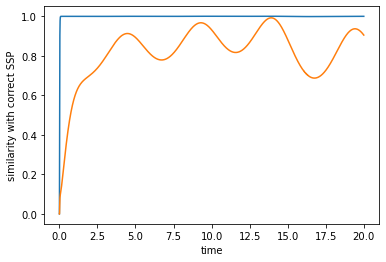

In [53]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_vco_dir = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


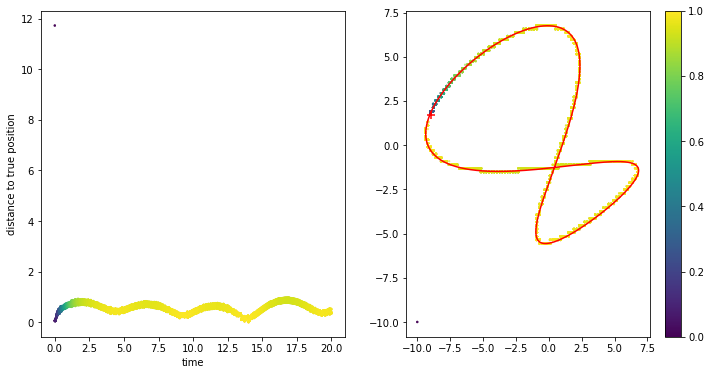

In [32]:
simpts_vco_dir, ptdists_vco_dir, ptconfid_vco_dir =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

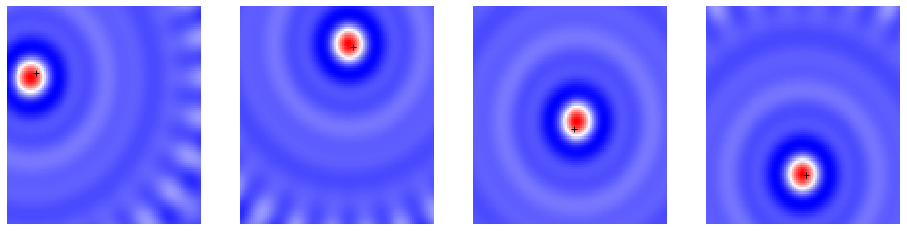

In [33]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In spiking mode:

In [67]:
#with model:
 #   connect.synapse = None

for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIF() 
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

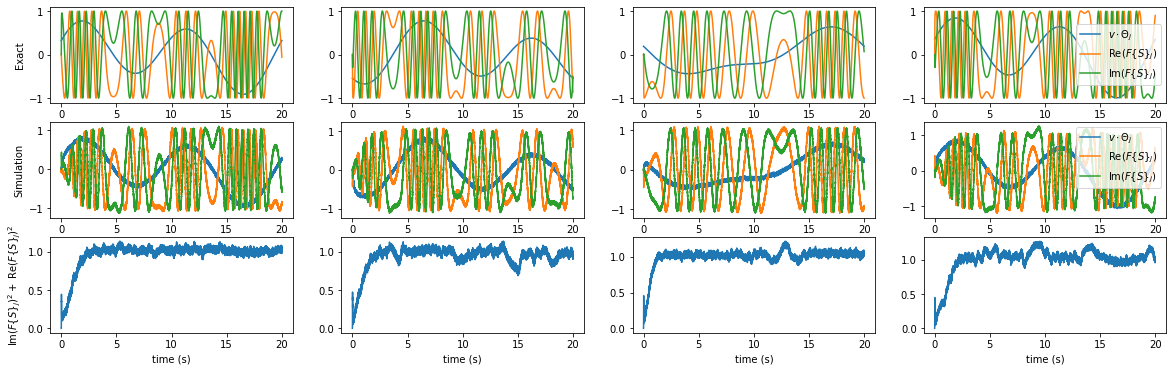

In [68]:
real_freqs_s = (vels_scaled @ myK.T)

sub_n_oscs = 4

figure(figsize=(20,6))
for i in np.arange(sub_n_oscs):
        
    j = i+ n_oscs - sub_n_oscs
    subplot(3,sub_n_oscs,i+1 )
    plot(sim.trange(), real_freqs_s[:, j])
    plot(sim.trange(), sim.data[real_p][:,[j, j + int(d//2)]])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$( F\{S\}_j)$","Im$(F\{S\}_j)$"])
        
    if i==0:
        ylabel("Exact")
    
    subplot(3,sub_n_oscs, i+1 + sub_n_oscs)
    plot(sim.trange(), sim.data[osc_p][:,(3*j):3*(j+1)])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$(F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Simulation")
    
    subplot(3,sub_n_oscs, i+1 + 2*sub_n_oscs)
    plot(sim.trange(), np.sqrt( sim.data[osc_p][:,3*j+1]**2 +  sim.data[osc_p][:,3*(j+1)-1]**2 ))
    if i==0:
        ylabel("Im$(F\{S\}_j)^2 + $ Re$(F\{S\}_j)^2$")
    xlabel("time (s)")

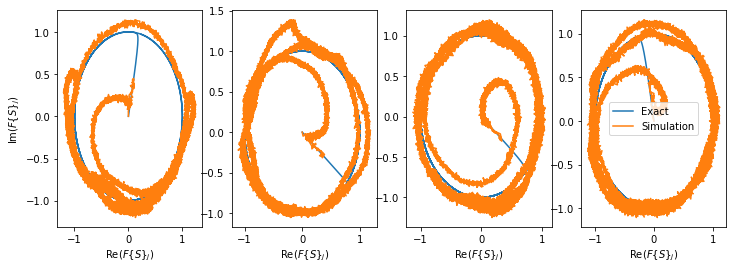

In [69]:
figure(figsize=(12,4))
for i in np.arange(sub_n_oscs):
    subplot(1,sub_n_oscs,i+1)
    plot(sim.data[real_p][:,i],  sim.data[real_p][:,i+ int(d//2)])
    plot(sim.data[osc_p][:,(3*i+1)], sim.data[osc_p][:,3*(i+1)-1])
    xlabel("Re$(F \{S\}_j)$")
    if i==0:
        ylabel("Im$(F\{S\}_j)$")
    if i==sub_n_oscs-1:
        legend(["Exact","Simulation"])

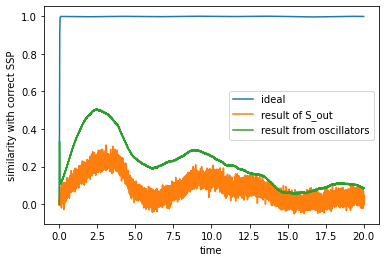

In [70]:
res_osc = (to_SSP @ sim.data[osc_p][:,S_ids].T).T

figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(res_osc*sim.data[real_ssp_p], axis=1))
legend(["ideal","result of S_out", "result from oscillators"])
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_vco_sp = sim.data[ssp_p]

<ipython-input-64-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


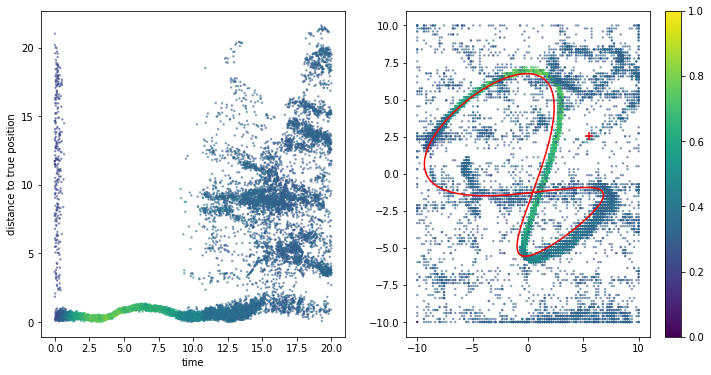

In [71]:
simpts_vco_sp, ptdists_vco_sp, ptconfid_vco_sp =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

From the oscillators (i.e. ignore noise from the pop post Fourier transform): 

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


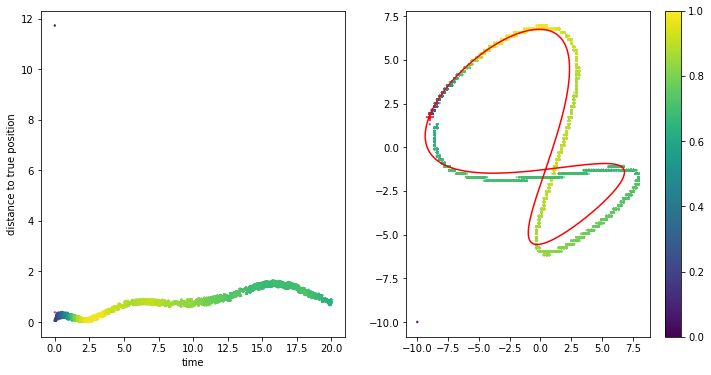

In [39]:
simpts_vco_sp2, ptdists_vco_sp2, ptconfid_vco_sp2 =  plot_sim_path(sim.trange(), res_osc, path)

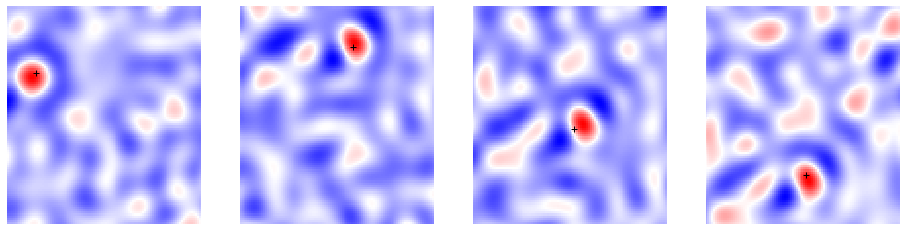

In [40]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

### With feedback from the grid cell population to the VCOs as a part of the dynamics

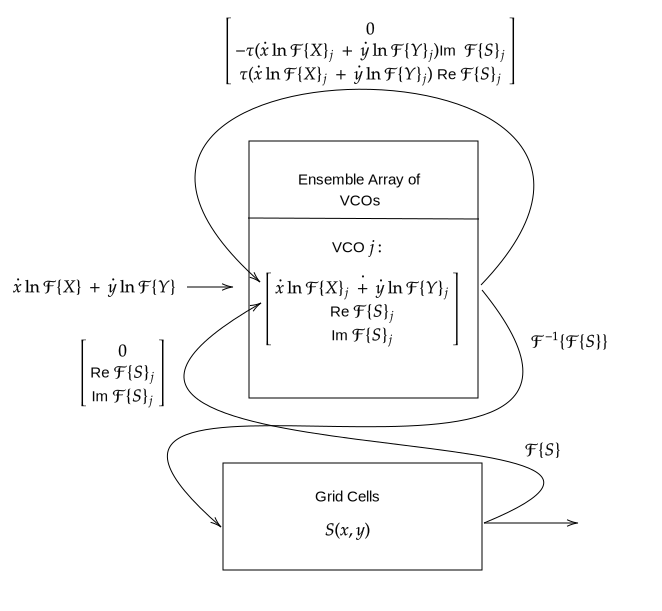

In [41]:
SVG(filename='diagram-20200821(3).svg')

In [23]:
#from nengolib import Alpha
tau = 0.1

model = nengo.Network(seed=1)
with model:
    vel_stim = nengo.Node(lambda t: vels_scaled[int(t/dt)-1,:], size_out=2)
    vel_input = nengo.Ensemble(n_neurons, dimensions=2,label='velocity')
    FS_real = nengo.Node(exact_Fssp) # just for probes
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    stim2 = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    node1 = nengo.Node([1,0,0])
    
    osc = nengo.networks.EnsembleArray(n_neurons, n_oscs + 1, ens_dimensions = 3,radius=np.sqrt(3), label="osc")
    osc.output.output = lambda t, x: x # a hack
    S_out = nengo.Ensemble(n_G, dimensions=d, encoders = G_encoders, eval_points=eval_pts, radius=np.sqrt(2), label="Sout")
    
    
    def feedback_stable2(x, tau):
        w = x[0]/scale_fac
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1, tau*dx2
    

    
    to_SSP = get_to_SSP_mat(d)
    i_to_SSP = get_from_SSP_mat(d)
    
    nengo.Connection(vel_stim, vel_input)
    for i in np.arange(n_oscs):
        nengo.Connection(vel_input, osc.ea_ensembles[i][0], transform = myK[i,:].reshape(1,-1),  
                         synapse=taus[i])
        nengo.Connection(osc.ea_ensembles[i], osc.ea_ensembles[i], 
                         function= lambda x: feedback_stable2(x, taus[i]), 
                         synapse=taus[i])
        
        S_back_mat = i_to_SSP[i_S_ids[2*i:(2*i+2)],:]
        nengo.Connection(S_out, osc.ea_ensembles[i][1:], transform=S_back_mat, synapse=tau)
        
    nengo.Connection(node1, osc.ea_ensembles[-1])
    nengo.Connection(osc.output[S_ids], S_out, transform = to_SSP, synapse=0) 
    #nengo.Connection(S_out, S_out, synapse=tau) 
    
    nengo.Connection(stim2, S_out)
    
    real_p = nengo.Probe(FS_real, synapse=.01)
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    osc_p = nengo.Probe(osc.output, synapse=.01)
    ssp_p = nengo.Probe(S_out, synapse=.01)



In direct mode:

In [24]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

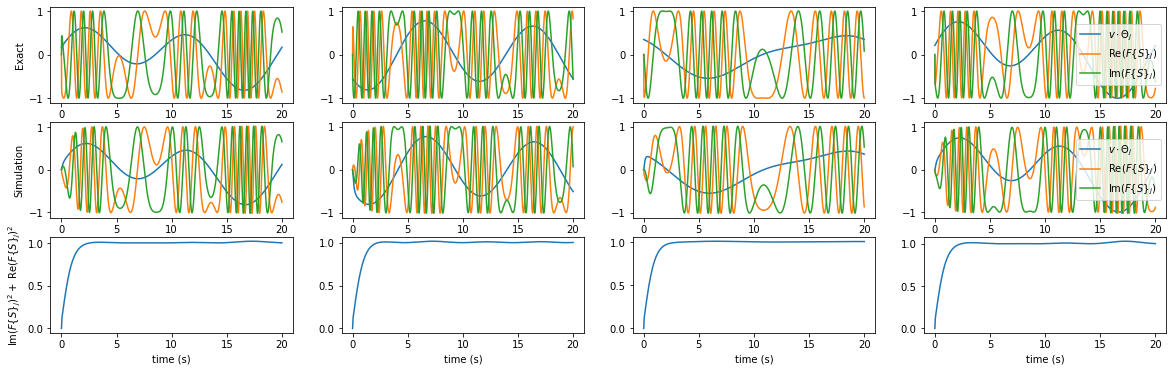

In [25]:
sub_n_oscs=4
real_freqs_s = (vels_scaled @ myK.T)
figure(figsize=(20,6))
for i in np.arange(sub_n_oscs):
        
    j = i+ n_oscs - sub_n_oscs
    subplot(3,sub_n_oscs,i+1 )
    plot(sim.trange(), real_freqs_s[:, j])
    plot(sim.trange(), sim.data[real_p][:,[j, j + int(d//2)]])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$( F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Exact")
    
    subplot(3,sub_n_oscs, i+1 + sub_n_oscs)
    plot(sim.trange(), sim.data[osc_p][:,(3*j):3*(j+1)])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$(F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Simulation")
    
    subplot(3,sub_n_oscs, i+1 + 2*sub_n_oscs)
    plot(sim.trange(), np.sqrt( sim.data[osc_p][:,3*j+1]**2 +  sim.data[osc_p][:,3*(j+1)-1]**2 ))
    if i==0:
        ylabel("Im$(F\{S\}_j)^2 + $ Re$(F\{S\}_j)^2$")
    xlabel("time (s)")

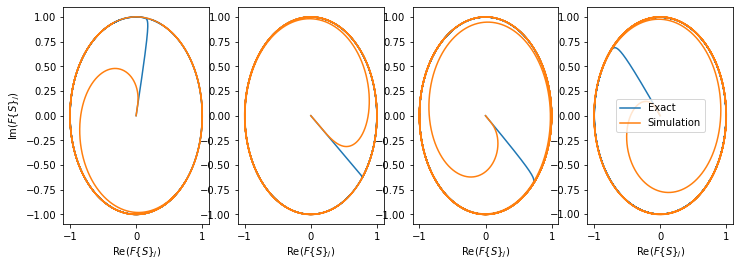

In [26]:
figure(figsize=(12,4))
for i in np.arange(sub_n_oscs):
    subplot(1,sub_n_oscs,i+1)
    plot(sim.data[real_p][:,i],  sim.data[real_p][:,i+ int(d//2)])
    plot(sim.data[osc_p][:,(3*i+1)], sim.data[osc_p][:,3*(i+1)-1])
    xlabel("Re$(F \{S\}_j)$")
    if i==0:
        ylabel("Im$(F\{S\}_j)$")
    if i==sub_n_oscs-1:
        legend(["Exact","Simulation"])

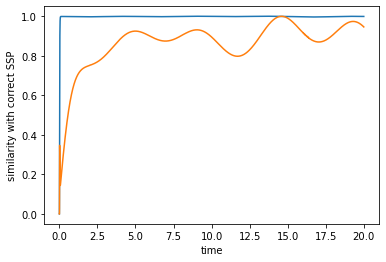

In [27]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_vcofeedback_sp = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


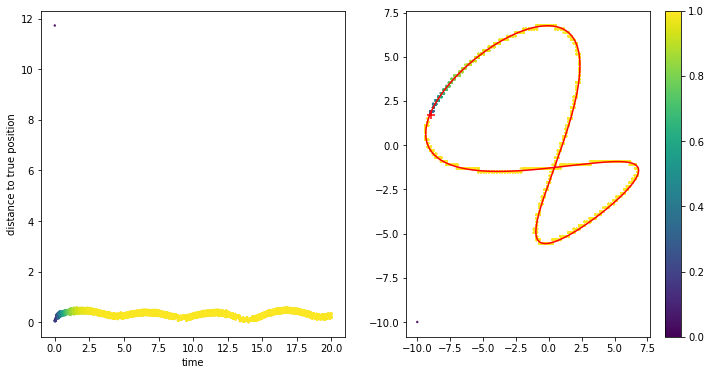

In [54]:
simpts_vcofeedback_sp, ptdists_vcofeedback_sp, ptconfid_vcofeedback_sp =  plot_sim_path(sim.trange(),
                                                                                        sim.data[ssp_p], path)

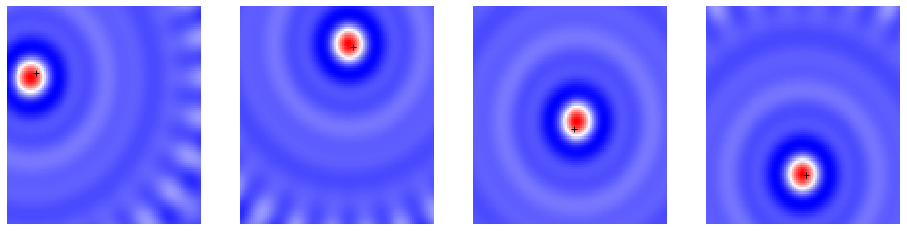

In [62]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In spiking mode:

In [28]:
for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIF() 
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

KeyboardInterrupt: 

In [39]:
np.tile(path, (3,1)).shape

(120000, 2)

SLAM

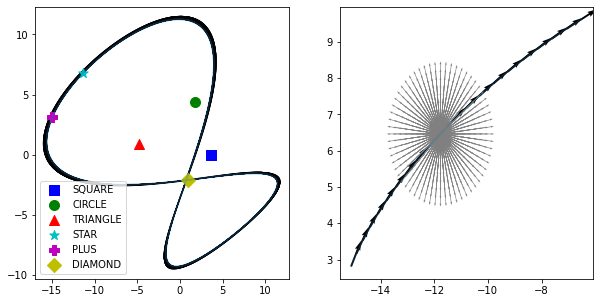

In [6]:
n_loops = 3
runT = 20*n_loops
dt = 0.001
timesteps = np.arange(0, runT, dt)
#path,_ = generate_signal(T, dt, dims=2, rms=8,limit=0.05, seed=2)
#path = 3*np.vstack([np.sin(2*np.pi*timesteps/T),np.cos(2*np.pi*timesteps/T) - 1]).T
path,_ = ssp.utils.generate_signal(runT/n_loops, dt, dims=2, rms=10,limit=0.1, seed=2)

path = np.tile(path, (n_loops,1))

rotation_matrix = lambda theta: np.stack([np.stack([np.cos(theta), -np.sin(theta)],axis=1),
           np.stack([np.sin(theta), np.cos(theta)], axis=1)], axis=1)
pathlen = path.shape[0]
vels = (1/dt)*( path[(np.minimum(floor(timesteps/dt) + 1, pathlen-1)).astype(int),:] -
               path[(np.minimum(floor(timesteps/dt), pathlen-2)).astype(int),:])
max_v = np.max(np.abs(vels))



item_names = ['SQUARE','CIRCLE','TRIANGLE','STAR','PLUS','DIAMOND']
items_markers = ["s","o","^","*","P","D"]
items_cols = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
num_items = 6
n_item_line = 3
line_pts = np.random.randint(0,path.shape[0],n_item_line)
item_locations = np.vstack([20*np.random.rand(num_items-n_item_line,2) - 10 ,np.array([path[line_pts,0],path[line_pts,1]]).T])



figure(figsize=(10,5))
subplot(1,2,1)
plot(path[:,0],path[:,1],alpha=0.3)
quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
legend()


K_hex = np.array([[0,1], [np.sqrt(3)/2,-0.5], [-np.sqrt(3)/2,-0.5]])
K_scales2 = np.vstack([K_hex*i for i in np.linspace(0.1,2,10)])
thetas2 = np.arange(0,20)*2*np.pi/(20)
obj_vecs = (rotation_matrix(thetas2) @ K_scales2.T).transpose(1,2,0).T.reshape(-1,2)
obj_vecs = np.vstack([[0,0],obj_vecs])
n_V = obj_vecs.shape[0]


subplot(1,2,2)
nsubpath = 2000
plot(path[0:nsubpath,0],path[0:nsubpath,1],alpha=0.3)
quiver(path[0:nsubpath:100,0],path[0:nsubpath:100,1], vels[0:nsubpath:100,0], vels[0:nsubpath:100,1], angles='xy', scale_units='xy',scale=5)
quiver(np.tile(path[nsubpath//2,0],n_V),np.tile(path[nsubpath//2,1],n_V), 
       obj_vecs[:,0],obj_vecs[:,1], angles='xy', scale_units='xy',scale=1, color='grey')


In [228]:
vels

array([[1.85104177, 3.5124533 ],
       [1.85439421, 3.51307428],
       [1.85774576, 3.5136943 ],
       ...,
       [1.84097902, 3.51058456],
       [1.84433417, 3.51120844],
       [1.84433417, 3.51120844]])

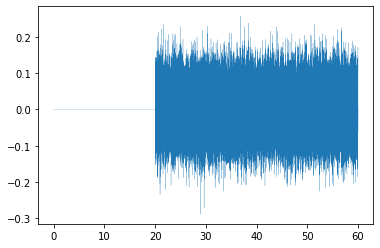

In [7]:
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.002))

v_noise = process.run((runT/n_loops)*(n_loops - 1))
v_noise = np.vstack([np.zeros((int((runT/n_loops)/dt),1)), v_noise])
plt.figure()
plt.plot(timesteps, v_noise, linewidth=0.2)



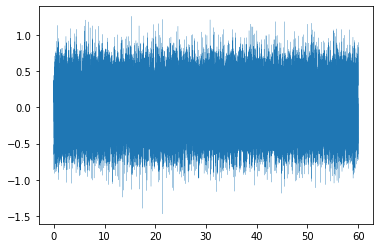

In [188]:
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.01))

v_noise = process.run(runT)
plt.figure()
plt.plot(timesteps, v_noise, linewidth=0.2)

In [8]:
vocab = spa.Vocabulary(d)
vocab.populate('.unitary();'.join(item_names[0:num_items]) + ".unitary()")

item_ssp = []
for i in np.arange(num_items):
    item_ssp.append(spa.SemanticPointer(data=(X**item_locations[i,0] * Y**item_locations[i,1]).v.real))
    if i==0:
        truemap = vocab[item_names[i]]*item_ssp[i]
    else:
        truemap = truemap + vocab[item_names[i]]*item_ssp[i]
        

In [9]:
item_sp = np.array([vocab[item_names[i]].v for i in np.arange(num_items)])

intercept = (np.dot(item_sp, item_sp.T) - np.eye(num_items)).flatten().max()
#intercept

In [21]:
item_ssp_M = np.array([s.v for s in item_ssp])
intercept2 = (np.dot(item_ssp_M, item_ssp_M.T) - np.eye(num_items)).flatten().max()

n_G=1000
G_pos = np.random.rand(n_G,2)*2*xy_rad - xy_rad

G_encoders, G_sorts = ssp.GridCellEncoders(n_G,X,Y,radius=xy_rad)

/usr/local/lib/python3.8/dist-packages/nengo_ssp-0.1.0-py3.8.egg/nengo_ssp/vector_generation.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  G_encoders[i,:] = N * proj_mat @ ((Xi**G_pos[i,0])*(Yi**G_pos[i,1])).v


In [12]:
from nengo.networks import EnsembleArray
from nengo.exceptions import ObsoleteError

# not using this anymore
class InputGatedMemory(nengo.Network):
    def __init__(
        self,
        n_neurons,
        dimensions,
        feedback=1.0,
        difference_gain=1.0,
        recurrent_synapse=0.1,
        difference_synapse=None,
        add_gain = 1.0,
        normalize=False,
        **kwargs
    ):

        if "net" in kwargs:
            raise ObsoleteError("The 'net' argument is no longer supported.")
        kwargs.setdefault("label", "Input gated memory")
        super().__init__(**kwargs)

        if difference_synapse is None:
            difference_synapse = recurrent_synapse

        n_total_neurons = n_neurons * dimensions

        with self:
            self.input = nengo.Node(size_in=dimensions)
            
            def normalize(x):
                return feedback*x/np.maximum(1e-8,np.sum(x**2))
            
            
            # integrator to store value
            self.mem = EnsembleArray(n_neurons, dimensions, label="mem")
            if normalize:
                self.mem.output.output = lambda t, x: x
                nengo.Connection(
                    self.mem.output,
                    self.mem.input,
                    function=normalize,
                    synapse=recurrent_synapse,
                )
            else:
                nengo.Connection(
                    self.mem.output,
                    self.mem.input,
                    transform=feedback,
                    synapse=recurrent_synapse,
                )

            # calculate difference between stored value and input
            self.diff = EnsembleArray(n_neurons, dimensions, label="diff")
            nengo.Connection(self.mem.output, self.diff.input, transform=-1.0)
            
            nengo.Connection(self.input,self.diff.input)
            
            self.add = EnsembleArray(n_neurons, dimensions, label="add")
            
            nengo.Connection(self.input,self.add.input)
            nengo.Connection(
                self.add.output,
                self.mem.input,
                transform= add_gain,
                synapse=difference_synapse,
            )

            # feed difference into integrator
            nengo.Connection(
                self.diff.output,
                self.mem.input,
                transform=difference_gain,
                synapse=difference_synapse,
            )

            # gate difference (if gate==0, update stored value,
            # otherwise retain stored value)
            self.gate = nengo.Node(size_in=1)
            self.diff.add_neuron_input()
            nengo.Connection(
                self.gate,
                self.diff.neuron_input,
                transform=np.ones((n_total_neurons, 1)) * -10,
                synapse=None,
            )
            
            self.gate_inv = nengo.Node(size_in=1, output = lambda t, x: x==0)
            nengo.Connection(self.gate, self.gate_inv)
            self.add.add_neuron_input()
            nengo.Connection(
                self.gate_inv,
                self.add.neuron_input,
                transform=np.ones((n_total_neurons, 1)) * -10,
                synapse=None,
            )

            # reset input (if reset=1, remove all values, and set to 0)
            self.reset = nengo.Node(size_in=1)
            nengo.Connection(
                self.reset,
                self.mem.add_neuron_input(),
                transform=np.ones((n_total_neurons, 1)) * -3,
                synapse=None,
            )

        #self.input = self.diff.input
        self.output = self.mem.output

In [28]:
d

151

In [22]:

n_neurons = n_G

myK = K_scale_rotates


    
OVC_encoders = ssp.utils.ssp_vectorized(np.vstack([X.v, Y.v]).T, obj_vecs).real.T

def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S
 

real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))

tau = 0.1
model = nengo.Network(seed=1)
with model:
    # Velocity input
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:] , label='velocity')#+ v_noise[int(t/dt)-1,:]
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    #stimF = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    
    
    # Path Int
    path_int = ssp.networks.PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y])
    path_int2 = ssp.networks.PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y]) # no error correction

    nengo.Connection(stim, path_int.input_SSP) #initialize
    nengo.Connection(stim_v, path_int.input_vel)
    
    nengo.Connection(stim, path_int2.input_SSP) #initialize
    nengo.Connection(stim_v, path_int2.input_vel)
    
    
    # From vision
    def vision_ssp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #truemap * ~vocab[item_names[i]]
                #deltaS = deltaS + (vocab[item_names[i]] * recall_ssp * ~spa.SemanticPointer(data=S.v)).v
                deltaS = deltaS + (recall_ssp * ~spa.SemanticPointer(data=S)).v
        deltaS = spa.SemanticPointer(data=deltaS).unitary().v
        return deltaS
    
    def vision_sp_fun(t):
        #S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                deltaS = deltaS + vocab[item_names[i]].v #* recall_ssp * ~spa.SemanticPointer(data=S.v)).v
        return deltaS
    
    
    vision_ssp_input = nengo.Node(vision_ssp_fun, label='obj_Dssp_input')
    vision_sp_input = nengo.Node(vision_sp_fun, label='obj_sp_input')
    
    ovc_ens = nengo.Ensemble(n_V, d, encoders= OVC_encoders, label='ovc')
    nengo.Connection(vision_ssp_input,ovc_ens)
    
    obj_ssp_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d, label='obj_ssp')
    nengo.Connection(path_int.output, obj_ssp_ens.input_a)
    nengo.Connection(ovc_ens, obj_ssp_ens.input_b)#ovc_ens
    
    obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d, label='obj')
    nengo.Connection(vision_sp_input, obj_ens.input_a)
    nengo.Connection(obj_ssp_ens.output, obj_ens.input_b)
    
    def sp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #
                deltaS = deltaS + (recall_ssp ).v
        deltaS = spa.SemanticPointer(data=deltaS).unitary().v
        return deltaS
    
    
    obj_to_ssp_recall = nengo.Node(sp_fun)
    
    
    # feed back into current location
    path_int_error = nengo.networks.EnsembleArray(n_neurons, d, 1)
    def gate_fun(t,x):
        if (np.sum(x[:d]*x[d:]) > 0.4) & (t > runT/n_loops):
            return 0  
        else:
            return 1000
    def gate_fun_direct(t,x):
        if np.any(np.linalg.norm(path[int(t/dt)-1,:] - item_locations,axis=1) <= 2) & (t > runT/n_loops):
            return 0.3*x
        else:
            return np.zeros(d)
            
    #path_int_gate = nengo.Node(size_in=d*2,size_out=1,output = gate_fun)
    #nengo.Connection(obj_to_ssp_recall, path_int_gate[:d])
    #nengo.Connection(obj_ssp_ens.output, path_int_gate[d:])
    pos_memory_estimate = spa.networks.CircularConvolution(n_neurons, d, label='pos_est',
                                                          invert_b = True)
    nengo.Connection(obj_to_ssp_recall, pos_memory_estimate.input_a)
    nengo.Connection(ovc_ens, pos_memory_estimate.input_b)
    nengo.Connection(pos_memory_estimate.output, path_int_error.input)
    nengo.Connection(path_int.output, path_int_error.input, transform=-1.0)
    nengo.Connection(path_int_error.output, path_int.input_SSP)
    path_int_error.output.output = gate_fun_direct
    #path_int_error.add_neuron_input()
   # nengo.Connection(
    #            path_int_gate,
     #           path_int_error.neuron_input,#transform=np.ones((n_neurons*d, 1)) * -10,
      #          synapse=None,
       #     )
    
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    ssp2_p = nengo.Probe(path_int2.output, synapse=.01)

    deltaS_p = nengo.Probe(ovc_ens , synapse=.01)
    obj_ssp_p = nengo.Probe(obj_ssp_ens.output , synapse=.01)
    obj_p = nengo.Probe(obj_ens.output , synapse=.01)
    path_error_p = nengo.Probe(path_int_error.output,synapse=.01)
    pos_est_p = nengo.Probe(pos_memory_estimate.output,synapse=.01)
    #gate_p = nengo.Probe(path_int_gate,synapse=.01)

    p_obj_to_ssp_recall = nengo.Probe(obj_to_ssp_recall, synapse=None)
    
    

    
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(runT)

/usr/local/lib/python3.8/dist-packages/nengo_spa-1.0.1-py3.8.egg/nengo_spa/semantic_pointer.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/ns2dumon/.local/lib/python3.8/site-packages/nengo/builder/operator.py:816: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [145]:
np.any(np.linalg.norm(path[int(9/dt)-1,:] - item_locations,axis=1) <= 2)

False

<ipython-input-66-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


<Figure size 432x288 with 0 Axes>

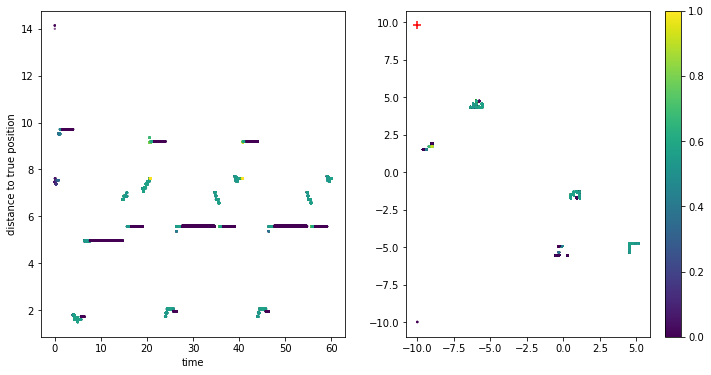

In [114]:
plt.figure()
_, _, _ =  plot_sim_path(ts, sim.data[obj_ssp_p], np.zeros((len(ts),2)))


<ipython-input-66-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


<Figure size 432x288 with 0 Axes>

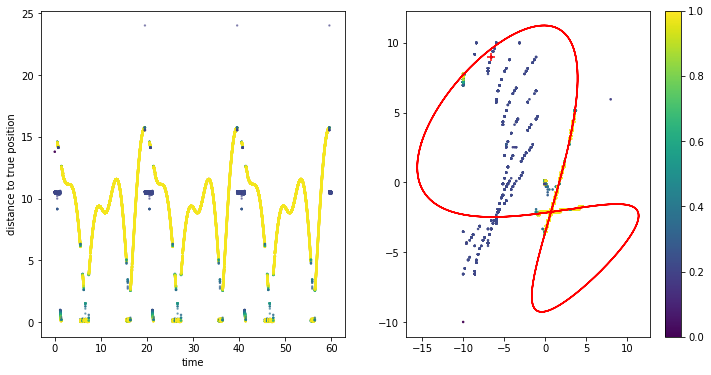

In [220]:
plt.figure()
_, _, _ =  plot_sim_path(ts, sim.data[pos_est_p], path)


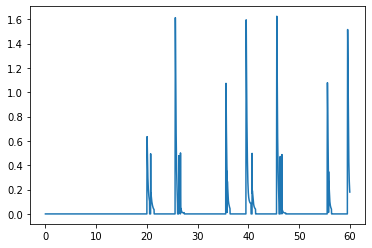

In [216]:
plt.figure()
loc_sims = np.sum(sim.data[path_error_p] * sim.data[path_error_p],axis=1)
plt.plot(ts,loc_sims);

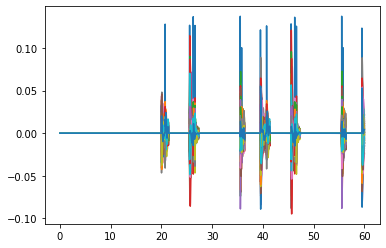

In [221]:
plt.figure()
plt.plot(ts,sim.data[path_error_p]);

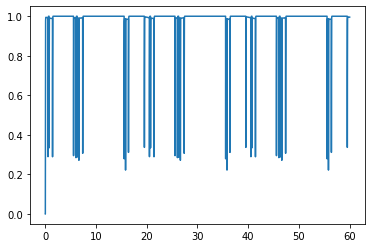

In [222]:
plt.figure()
loc_sims = np.sum(sim.data[pos_est_p] * sim.data[pos_est_p],axis=1)
plt.plot(ts,loc_sims);

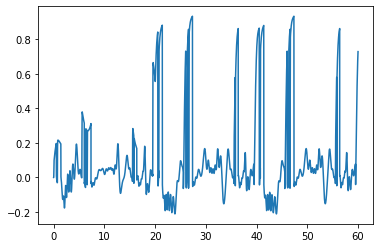

In [26]:
plt.figure()
loc_sims = np.sum(sim.data[obj_ssp_p] * sim.data[p_obj_to_ssp_recall],axis=1)
plt.plot(ts,loc_sims);

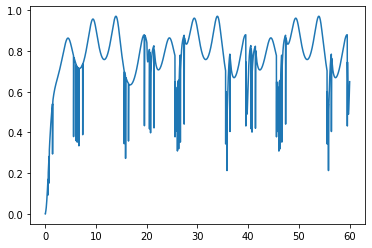

In [25]:
plt.figure()
loc_sims = np.sum(sim.data[obj_ssp_p] * sim.data[obj_ssp_p],axis=1)
plt.plot(ts,loc_sims);

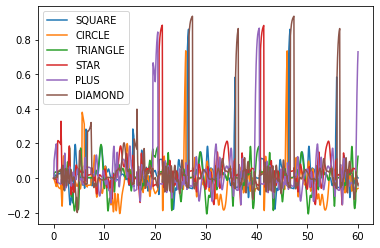

In [24]:
plt.figure()
loc_sims = sim.data[obj_ssp_p] @ np.array([ s.v for s in item_ssp]).T
plt.plot(ts,loc_sims);
plt.legend(item_names)

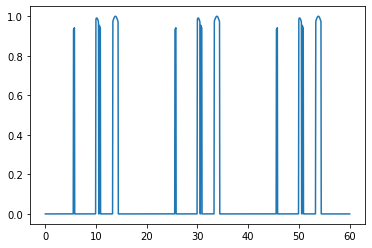

In [183]:
plt.figure()
plot(ts,np.sum(sim.data[deltaS_p]*sim.data[deltaS_p], axis=1))


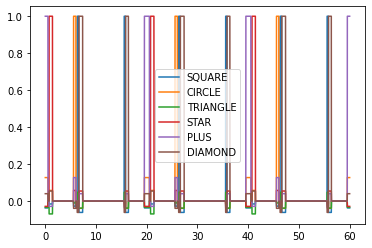

In [210]:
plt.figure()
loc_sims = sim.data[p_obj_to_ssp_recall] @ np.array([ s.v for s in item_ssp]).T
plt.plot(ts,loc_sims);
plt.legend(item_names)

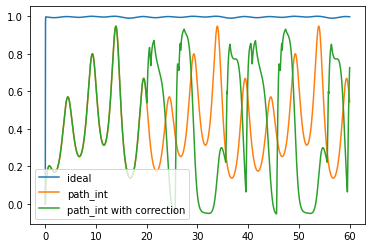

In [23]:
ts = sim.trange()
figure()
plot(ts,np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(ts,np.sum(sim.data[ssp2_p]*sim.data[real_ssp_p], axis=1))
plot(ts,np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
legend(["ideal","path_int","path_int with correction"])

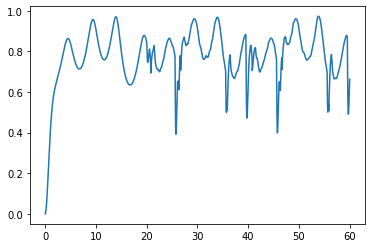

In [214]:
plot(ts,np.sum(sim.data[ssp_p]*sim.data[ssp_p], axis=1))


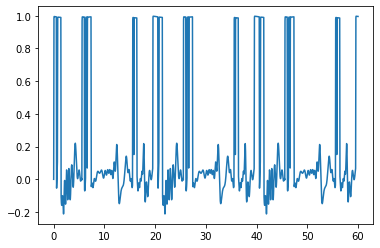

In [237]:
plot(ts,np.sum(sim.data[pos_est_p]*sim.data[real_ssp_p], axis=1))

<ipython-input-4-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


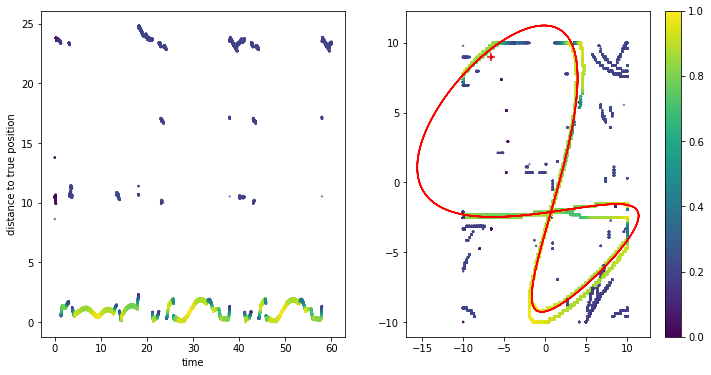

In [20]:
simpts_vco_dir, ptdists_vco_dir, ptconfid_vco_dir =  plot_sim_path(ts, sim.data[ssp_p], path)

<ipython-input-66-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


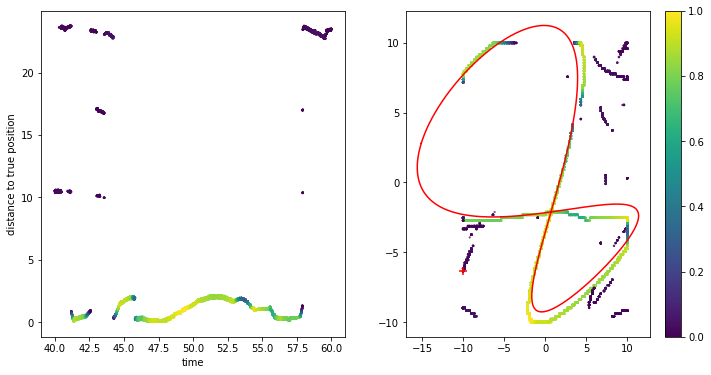

In [206]:
idxs = np.arange(int((runT/n_loops)*(n_loops-1)/dt), int(runT/dt))
simpts_vco_dir, ptdists_vco_dir, ptconfid_vco_dir =  plot_sim_path(ts[idxs], sim.data[ssp_p][idxs,:], path[idxs,:])

<ipython-input-66-adff5635ddd9>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


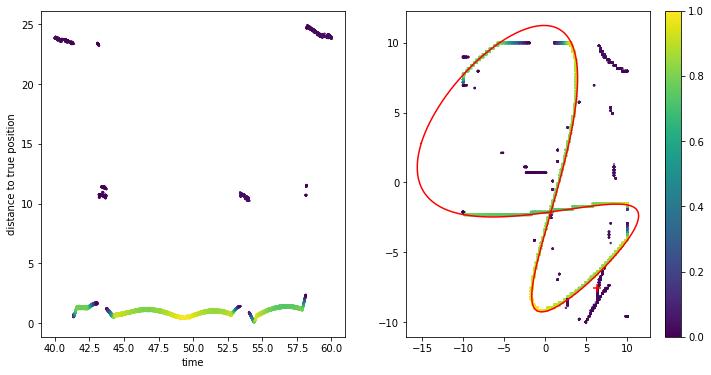

In [232]:
simpts_vco_dir, ptdists_vco_dir, ptconfid_vco_dir =  plot_sim_path(ts[idxs], sim.data[ssp2_p][idxs,:], path[idxs,:])

In [26]:
path.shape

(20000, 2)

In [44]:

n_neurons = n_G

myK = K_scale_rotates


    
OVC_encoders = ssp.utils.ssp_vectorized(np.vstack([X.v, Y.v]).T, obj_vecs).real.T

def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S
 

real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))

tau = 0.1
model = nengo.Network(seed=1)
with model:
    # Velocity input
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:], label='velocity')
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    #stimF = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    
    
    # Path Int
    path_int = ssp.networks.PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y])

    nengo.Connection(stim, path_int.input_SSP) #initialize
    nengo.Connection(stim_v, path_int.input_vel)
    
    
    # From vision
    def vision_ssp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #truemap * ~vocab[item_names[i]]
                #deltaS = deltaS + (vocab[item_names[i]] * recall_ssp * ~spa.SemanticPointer(data=S.v)).v
                deltaS = deltaS + (recall_ssp * ~spa.SemanticPointer(data=S)).v
        return deltaS
    
    def vision_sp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                deltaS = deltaS + vocab[item_names[i]].v #* recall_ssp * ~spa.SemanticPointer(data=S.v)).v
        return deltaS
    
    
    vision_ssp_input = nengo.Node(vision_ssp_fun, label='obj_Dssp_input')
    vision_sp_input = nengo.Node(vision_sp_fun, label='obj_sp_input')
    
    ovc_ens = nengo.Ensemble(n_V, d, encoders= OVC_encoders, label='ovc')
    nengo.Connection(vision_ssp_input,ovc_ens)
    
    obj_ssp_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d, label='obj_ssp')
    nengo.Connection(path_int.output, obj_ssp_ens.input_a)
    nengo.Connection(ovc_ens, obj_ssp_ens.input_b)
    
    obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d, label='obj')
    nengo.Connection(vision_sp_input, obj_ens.input_a)
    nengo.Connection(obj_ssp_ens.output, obj_ens.input_b)
    
    
    obj_to_ssp_memory = nengo.Ensemble(n_neurons, d, intercepts = [intercept]*n_neurons, label='obj_to_ssp_mem')
    learning = nengo.Node(output=lambda t: -int(t >= runT / 2))
    recall1 = nengo.Node(size_in=d)
    
    # Learn the encoders/keys
    voja1 = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn_in1 = nengo.Connection(vision_sp_input, obj_to_ssp_memory, synapse=None, learning_rule_type=voja1)
    nengo.Connection(learning, conn_in1.learning_rule, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out1 = nengo.Connection(
        obj_to_ssp_memory,
        recall1,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d),
    )

    # Create the error population
    error1 = nengo.Ensemble(n_neurons, d, label='error1')
    nengo.Connection(
        learning, error1.neurons, transform=[[10.0]] * n_neurons, synapse=None
    )

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(obj_ssp_ens.output, error1, transform=-1, synapse=None)
    nengo.Connection(recall1, error1, synapse=None)
    nengo.Connection(error1, conn_out1.learning_rule)
    
    
    
    ssp_to_obj_memory = nengo.Ensemble(n_neurons, d, encoders=G_encoders,intercepts = [intercept2]*n_neurons, label='ssp_to_obj_mem')
    voja2 = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn_in2 = nengo.Connection(obj_ssp_ens.output, ssp_to_obj_memory, synapse=None, learning_rule_type=voja2)
    nengo.Connection(learning, conn_in2.learning_rule, synapse=None)
    recall2 = nengo.Node(size_in=d)
    conn_out2 = nengo.Connection(
        ssp_to_obj_memory,
        recall2,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d),
    )

    error2 = nengo.Ensemble(n_neurons, d, label='error2')
    nengo.Connection(
        learning, error2.neurons, transform=[[10.0]] * n_neurons, synapse=None
    )
    nengo.Connection(vision_sp_input, error2, transform=-1, synapse=None)
    nengo.Connection(recall2, error2, synapse=None)
    nengo.Connection(error2, conn_out2.learning_rule)
    
    
    def normalize(t,x):
        return x/np.maximum(1e-9, np.sum(x**2))
    
    memory = nengo.networks.EnsembleArray(n_neurons, d, 
                          ens_dimensions = 1,radius=1, label="scene_working_memory")
    nengo.Connection(obj_ens.output,memory.input)
    nengo.Connection(memory.output,memory.input)
    memory.output.output = normalize

    
    
    
    # feed back into current location
    path_int_error = nengo.networks.EnsembleArray(n_neurons, d, 1)
    path_int_gate = nengo.Node(size_in=d*2,size_out=1,output = lambda t,x: 0 if np.sum(x[:d]*x[d:]) > 0.7 else 1)
    nengo.Connection(recall1, path_int_gate[:d])
    nengo.Connection(obj_ssp_ens.output, path_int_gate[d:])
    pos_memory_estimate = spa.networks.CircularConvolution(n_neurons, d, label='pos_est',
                                                          invert_b = True)
    nengo.Connection(recall1, pos_memory_estimate.input_a)
    nengo.Connection(ovc_ens, pos_memory_estimate.input_b)
    nengo.Connection(pos_memory_estimate.output, path_int_error.input)
    nengo.Connection(path_int.output, path_int_error.input, transform=-1.0)
    nengo.Connection(path_int_error.output, path_int.input_SSP, transform=0.5)
    path_int_error.add_neuron_input()
    nengo.Connection(
                path_int_gate,
                path_int_error.neuron_input,
                transform=np.ones((n_neurons*d, 1)) * -10,
                synapse=None,
            )
    
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    deltaS_p = nengo.Probe(ovc_ens , synapse=.01)
    obj_ssp_p = nengo.Probe(obj_ssp_ens.output , synapse=.01)
    obj_p = nengo.Probe(obj_ens.output , synapse=.01)
    obj_to_ssp_memory_p = nengo.Probe(obj_to_ssp_memory, synapse=.01)
    ssp_to_obj_memory_p = nengo.Probe(obj_to_ssp_memory, synapse=.01)
    
    
    p_learning = nengo.Probe(learning, synapse=None)
    p_error1 = nengo.Probe(error1, synapse=0.005)
    p_recall1 = nengo.Probe(recall1, synapse=None)
    p_error2 = nengo.Probe(error2, synapse=0.005)
    p_recall2 = nengo.Probe(recall2, synapse=None)
    
    #t_p = nengo.Probe(time_cells , synapse=.01)
    #obj_t_p = nengo.Probe(time_obj_ens.output , synapse=.01)
    memory_p = nengo.Probe(memory.output , synapse=.01)

    
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(runT)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/builder/operator.py:816: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

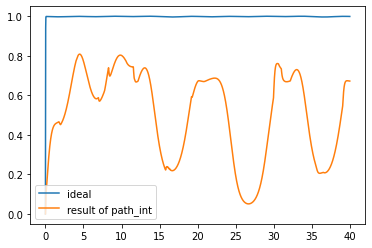

In [45]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
legend(["ideal","result of path_int"])

(-10.0, -2.0)

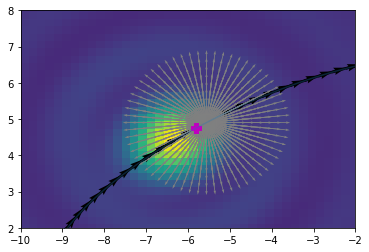

In [47]:
figure()
nsubpath = 3000

ssp.plotting.similarity_plot(X, Y, xs, ys, S0 = sim.data[obj_ssp_p][nsubpath//2,:])

plot(path[0:nsubpath,0],path[0:nsubpath,1],alpha=0.3)
quiver(path[0:nsubpath:100,0],path[0:nsubpath:100,1], vels[0:nsubpath:100,0], vels[0:nsubpath:100,1], angles='xy', scale_units='xy',scale=5)
quiver(np.tile(path[nsubpath//2,0],n_V),np.tile(path[nsubpath//2,1],n_V), 
       obj_vecs[:,0],obj_vecs[:,1], angles='xy', scale_units='xy',scale=1, color='grey')
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
ylim([2,8])
xlim([-10,-2])

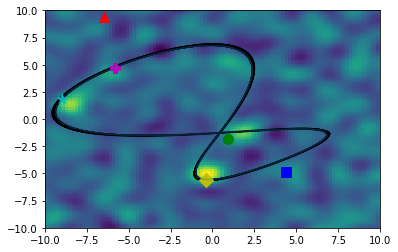

In [48]:
figure()
ssp.plotting.similarity_plot(X, Y, xs, ys, S0 = np.sum(sim.data[obj_ssp_p],axis=0))
plot(path[:,0],path[:,1],alpha=0.3)
quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])

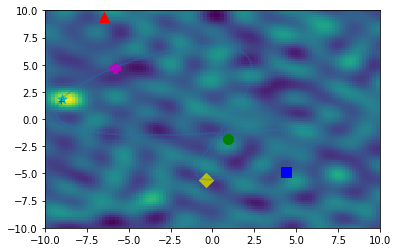

In [50]:
ex_t = len(sim.trange())-1
ex_M = spa.SemanticPointer(data=sim.data[memory_p][ex_t,:])
ex_Obj = vocab['STAR']
#ex_T = spa.SemanticPointer(data=sim.data[t_p][ex_t,:])


figure()
ssp.plotting.similarity_plot(X, Y, xs, ys, S0 = (ex_M * ~ex_Obj).v)
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
plot(path[ex_t,0],path[ex_t,1],'+r')

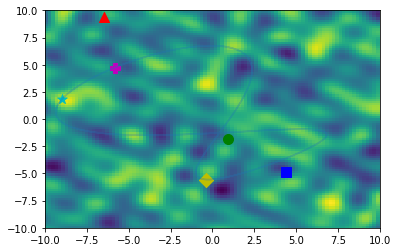

In [51]:
Msum = np.zeros(d)
for i in np.arange(num_items):
    Mt = (spa.SemanticPointer(data=sim.data[memory_p][-1,:]) * ~vocab[item_names[i]]).v
    Msum = Msum + Mt


figure()
ssp.plotting.similarity_plot(X, Y, xs, ys, S0 = Msum )
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
#plot(path[ex_t,0],path[ex_t,1],'+r')

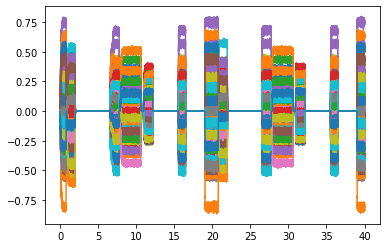

In [52]:
plt.figure()
plt.plot(sim.trange(), sim.data[obj_to_ssp_memory_p]);

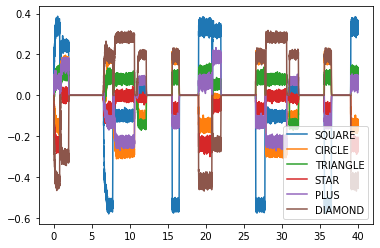

In [53]:
plt.figure()
plt.plot(sim.trange(), sim.data[obj_to_ssp_memory_p] @ np.array([s.v for s in item_ssp]).T)
plt.legend(item_names)

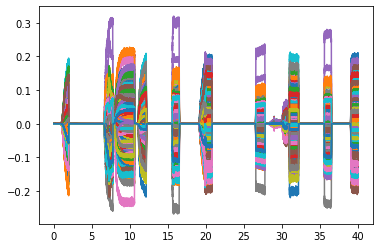

In [54]:
plt.figure()
plt.plot(sim.trange(), sim.data[p_recall2]);

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


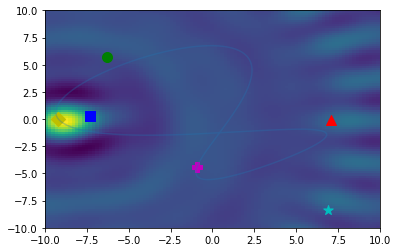

In [66]:
figure()
similarity_plot(X, Y, xs, ys, S0 = sim.data[memory_p][-1,:] )
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])